# 時系列データのベーストレンド変化を求めて回帰成分によるadd-onを算出
---
- 広告による獲得ユーザー数の効果測定のような場面を想定する  
- 単なる線形回帰で広告の効果を算出しようとすると、ベーストレンドの変化を考慮しないために効果を適切に算出できない  
- そこで、状態空間モデル(ベーストレンド推移を考慮)/線形回帰(ベーストレンド一定) で結果を比較した  
<br />
(参考)  
K. H. Brodersen et al., "Inferring causal impact using Bayesian structural time-series models", 2015.  
https://google.github.io/CausalImpact/CausalImpact.html  
https://ai.google/research/pubs/pub41854  
<br />
高柳慎一, "状態空間モデルを活用した時系列データのCausalImpact分析", 2014  
https://speakerdeck.com/stakaya/zhuang-tai-kong-jian-moderuwohuo-yong-sita-shi-xi-lie-detafalsecausalimpactfen-xi

- pythonで状態空間モデルを扱うライブラリはstatsmodelsなどがあるが、回帰成分が複数だと使いづらい
- ここでは、RStanによる似た実装が多いこともあり(上記)、PyStanで実装  
- 線形回帰はscikit-learnで実装する  

In [1]:
from time import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.random import normal
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pystan
from sklearn.linear_model import LinearRegression

plt.style.use('ggplot')

## サンプルデータの生成
---
- ベーストレンド  
  - 適当な推移を持つトレンド(ここではsinカーブ)にガウシアンノイズを乗せる  
  - ノイズの強さは適当  
- 周期成分  
  - 周期は既知とする(週次の推移)  
- 回帰成分
  - 時期によっては重複しながら、効果の異なる3種類のチャネルの広告が投下されている想定  
  - 広告の実施時期のみ既知とする  

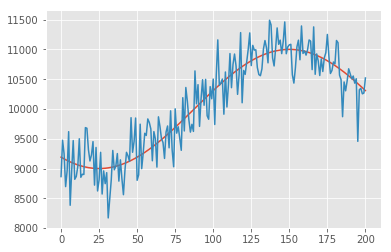

In [2]:
# ベーストレンド
np.random.seed(123)

x = np.linspace(-np.pi * 0.7, np.pi * 0.9, 201)
noise = normal(0, 300, 201)
y_base_wo_noise = np.sin(x) * 1000 + 10000
y_base = y_base_wo_noise + noise

plt.plot(y_base_wo_noise)
plt.plot(y_base)
plt.show()

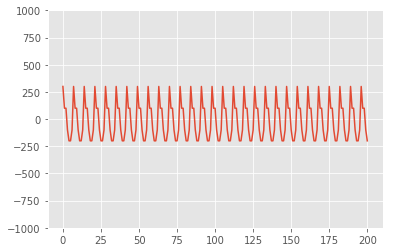

In [3]:
# 周期成分
x = np.linspace(0, 200, 201)
y_dow = np.zeros(201)
cycle = 7        # 周期は既知とする

for i in range(201):
    if x[i] % cycle == 0:
        y_dow[i] = 0.3
    elif x[i] % cycle == 1:
        y_dow[i] = 0.1
    elif x[i] % cycle == 2:
        y_dow[i] = 0.1
    elif x[i] % cycle == 3:
        y_dow[i] = -0.1
    elif x[i] % cycle == 4:
        y_dow[i] = -0.2
    elif x[i] % cycle == 5:
        y_dow[i] = -0.2
    elif x[i] % cycle == 6:
        y_dow[i] = -0.1

y_dow = list(map(lambda x: x * 1000, y_dow))

plt.plot(y_dow)
plt.ylim(-1000, 1000)
plt.show()

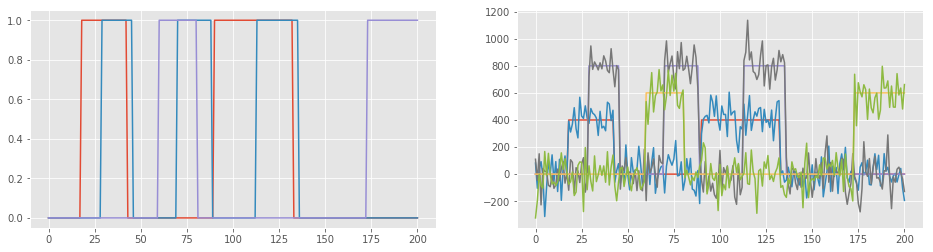

In [4]:
# 回帰成分
plt.figure(figsize=(16, 4))

x = np.linspace(0, 200, 201)
x_reg1 = [1 if ((x[i] >=18) & (x[i] <= 42)) 
                        | ((x[i] >= 90) & (x[i] <= 132)) else 0 for i in range(201)]
x_reg2 = [1 if ((x[i] >=29) & (x[i] <= 45)) 
                        | ((x[i] >= 70) & (x[i] <= 88))
                        | ((x[i] >= 113) & (x[i] <= 135)) else 0 for i in range(201)]
x_reg3 = [1 if (x[i] >= 60) & (x[i] <= 80) 
                        | ((x[i] >= 173) & (x[i] <= 205)) else 0 for i in range(201)]

plt.subplot(1, 2, 1)
plt.plot(x_reg1)
plt.plot(x_reg2)
plt.plot(x_reg3)


np.random.seed(234)
noise1 = normal(0, 100, 201)
noise2 = normal(0, 100, 201)
noise3 = normal(0, 100, 201)
mpr1 = 400
mpr2 = 800
mpr3 = 600
y_reg1_wo_noise = list(map(lambda x: x * mpr1, x_reg1))
y_reg1 = y_reg1_wo_noise + noise1
y_reg2_wo_noise = list(map(lambda x: x * mpr2, x_reg2))
y_reg2 = y_reg2_wo_noise + noise2
y_reg3_wo_noise = list(map(lambda x: x * mpr3, x_reg3))
y_reg3 = y_reg3_wo_noise + noise3

plt.subplot(1, 2, 2)
plt.plot(y_reg1_wo_noise)
plt.plot(y_reg1)
plt.plot(y_reg2_wo_noise)
plt.plot(y_reg2)
plt.plot(y_reg3_wo_noise)
plt.plot(y_reg3)
plt.show()

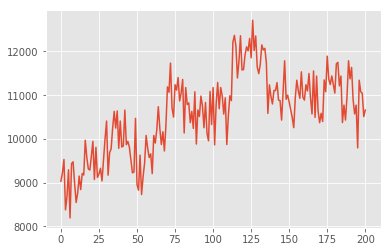

In [5]:
# ベーストレンド, 周期成分, 回帰成分を足してサンプルデータセットを生成
y = y_base + y_dow + y_reg1 + y_reg2 + y_reg3
plt.plot(y)
plt.show()

## 状態空間モデル/線形回帰で推定
---
- MCMCサンプリングはすべての変数で Rhat<1.1 を満たした(+実績値vs予測値の比較も考慮して)ので収束したとみなす  

状態空間モデル

In [6]:
# Stanモデルのコンパイル
t0 = time()
sm = pystan.StanModel(file = '../model/state_space_model.stan')
print('Compiling Stan model in {:.2f}s'.format(time() - t0))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bdf530d5d3b617bec1bdc0bc345d499d NOW.


Compiling Stan model in 39.24s


In [7]:
# MCMCサンプリング
stan_data = {'t_max': len(y), 'y': y, 'x1': x_reg1, 'x2': x_reg2, 'x3': x_reg3}
t0 = time()
fit = sm.sampling(data = stan_data, iter=8000, warmup=500, seed=1, chains=3)
print('MCMC sampling in: {:.2f}s'.format(time() - t0))
display(fit)

MCMC sampling in: 773.81s


Inference for Stan model: anon_model_bdf530d5d3b617bec1bdc0bc345d499d.
3 chains, each with iter=8000; warmup=500; thin=1; 
post-warmup draws per chain=7500, total post-warmup draws=22500.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
trend[0]         7.66    0.52  14.69 -21.96  -1.45   7.48  16.81  37.57    793    1.0
trend[1]         7.68    0.51  14.13  -20.8  -1.01   7.57  16.43  36.37    764    1.0
trend[2]         7.71     0.5  13.52 -19.64  -0.77   7.55  16.17  35.24    729   1.01
trend[3]         7.69    0.49  12.93 -18.53   -0.5   7.68  15.84  33.51    707   1.01
trend[4]         7.71    0.47  12.43 -17.33  -0.21   7.62  15.63  32.82    689   1.01
trend[5]         7.64    0.46  11.98 -16.26   0.08   7.63  15.21  31.91    691   1.01
trend[6]         7.62    0.43  11.47 -14.97   0.29   7.57  14.88  30.45    702   1.01
trend[7]          7.6    0.42  11.06 -13.98    0.5   7.48  14.58  29.66    704   1.01
trend[8]         7.55     0.4  10.69 

In [8]:
# Rhatを降順に表示
feats = fit.sim['fnames_oi']
irhat = fit.summary()['summary_colnames']
irhat = irhat.index('Rhat')
rhat = fit.summary()['summary'][:, irhat]

rhat_df = pd.DataFrame({'feats': feats, 'Rhat': rhat})
display(rhat_df.sort_values('Rhat', ascending=False))

,Rhat,feats
261,1.046512,dow[60]
275,1.046132,dow[74]
268,1.045717,dow[67]
282,1.044926,dow[81]
254,1.044141,dow[53]
317,1.043321,dow[116]
310,1.043140,dow[109]
289,1.041938,dow[88]
324,1.041827,dow[123]
303,1.041078,dow[102]


線形回帰

In [9]:
# 線形回帰
t0 = time()
x_train = pd.concat([
    pd.DataFrame(x_reg1),
    pd.DataFrame(x_reg2),
    pd.DataFrame(x_reg3)
], axis=1)
y_train = y
model = LinearRegression()
model.fit(x_train, y_train)
print('Fitting linear regression model in: {:.2f}s'.format(time() - t0))

Fitting linear regression model in: 0.00s


## 推定結果を抽出
---
- 回帰成分の係数を比較すると、ch1, 2 では状態空間モデルの方が元の係数に近いが、ch3 では線形回帰のほうが近く、何とも言えない  

In [10]:
from scipy.stats import gaussian_kde

def kde_mode(y):
    """
    Parameters
    y: 任意の確率分布(scipyオブジェクト)
    
    Returns
    kde: カーネル密度推定結果(n_grid個に離散化) → 今は使わないので出力値から外す
    x_mode: カーネル密度が最大になるx
    """
    n_grid = 100
    x = np.linspace(min(y), max(y), num=n_grid)
    kde = [gaussian_kde(y)(x[i])[0] for i in range(n_grid)]

    kde_df = pd.DataFrame({'x': x, 'kde': kde})
    x_mode = kde_df[kde_df['kde']==kde_df['kde'].max()]['x'].values[0]
    
    return x_mode

In [11]:
feat_x = ['ch1', 'ch2', 'ch3']
extract_method = 'mean'

# 表示する変数を指定
feat_y_pred = 'y_pred'
feat_trend = 'trend'
feat_dow = 'dow'
feat_a = ['a1', 'a2', 'a3']
feat_b = 'b'

y_pred_arr = fit.extract(feat_y_pred)[feat_y_pred]
y_trend_arr = fit.extract(feat_trend)[feat_trend]
y_dow_arr = fit.extract(feat_dow)[feat_dow]
y_a_arr = [fit.extract(feat)[feat] for feat in feat_a]
y_b_arr = fit.extract(feat_b)[feat_b]

# 代表値を抽出
if extract_method == 'mean':        # 代表値: 平均値
    # 予測値、トレンド成分
    y_pred = y_pred_arr.mean(axis=0)
    y_trend = y_trend_arr.mean(axis=0)

    # 周期成分
    y_dow = y_dow_arr.mean(axis=0)

    # 回帰成分
    y_a = [a.mean(axis=0) for a in y_a_arr]
    y_b = y_b_arr.mean(axis=0)

    # トレンド推移(トレンド成分+回帰成分の定数項)
    cum_mean = np.cumsum(y_trend)
    trend = cum_mean + y_b

elif extract_method == 'mode':         # 代表値: KDE最頻値→少し時間がかかる
    print('\nThis method takes a few seconds. Please wait.....')
    t0 = time()

    # 予測値、トレンド成分
    y_pred = [kde_mode(prd) for prd in y_pred_arr.T]
    y_trend = [kde_mode(trd) for trd in y_trend_arr.T]

    # 周期成分
    y_dow = [kde_mode(dow) for dow in y_dow_arr.T]

    # 回帰成分
    y_a = [kde_mode(a) for a in y_a_arr]
    y_b = kde_mode(y_b_arr)

    # トレンド推移(トレンド成分+回帰成分の定数項)
    cum_weight = np.cumsum(y_trend)
    trend = cum_weight + y_b

    print('Processing done in {:.2f}s \n'.format(time() -  t0))

# 回帰成分の係数を表示
print('Actual:')
print('Coefficient of x0: {:8.4f}   ({})'.format(mpr1, feat_x[0]))
print('Coefficient of x1: {:8.4f}   ({})'.format(mpr2, feat_x[1]))
print('Coefficient of x2: {:8.4f}   ({})'.format(mpr3, feat_x[2]))

print('\nState space model:')
for i in range(3):
    print('Coefficient of x{}: {:8.4f}   ({})'.format(str(i), y_a[i], feat_x[i]))

print('\nLinear regression:')
for i in range(3):
    print('Coefficient of x{}: {:8.4f}   ({})'.format(str(i), model.coef_[i], feat_x[i]))

Actual:
Coefficient of x0: 400.0000   (ch1)
Coefficient of x1: 800.0000   (ch2)
Coefficient of x2: 600.0000   (ch3)

State space model:
Coefficient of x0: 285.1998   (ch1)
Coefficient of x1: 737.7676   (ch2)
Coefficient of x2: 536.0352   (ch3)

Linear regression:
Coefficient of x0: 242.6348   (ch1)
Coefficient of x1: 696.4611   (ch2)
Coefficient of x2: 595.0098   (ch3)


## 推定結果を図化
---
- 元データと予測値を時系列推移と比較すると、状態空間モデルの方が当てはまりが良いことがわかる  

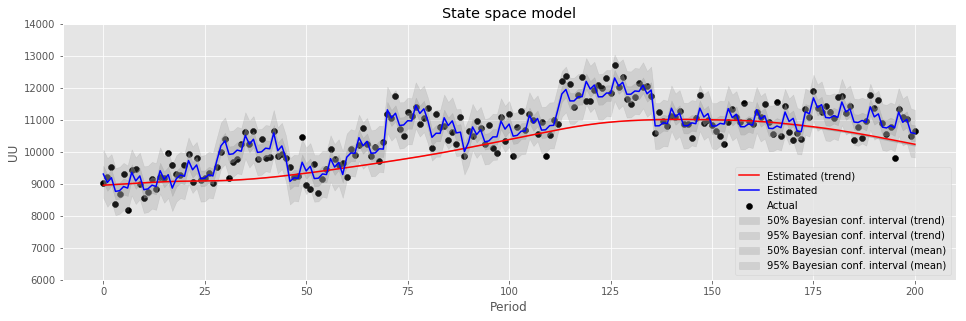

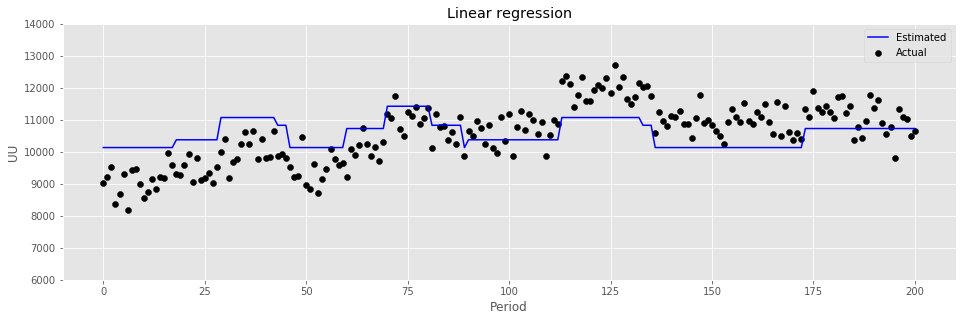

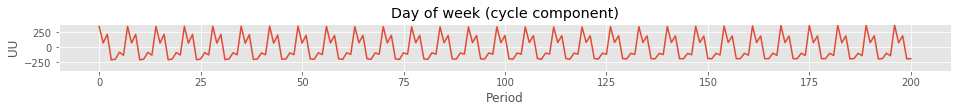

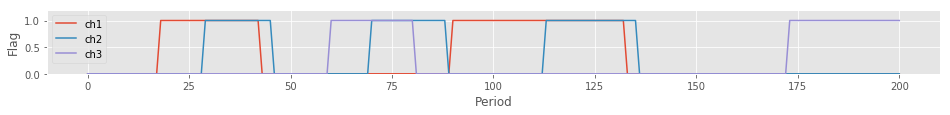

In [12]:
# 推定結果を図化
plt.figure(figsize=(16, 16))
plt.subplot(3, 1, 1)

x = np.linspace(0, 200, 201)
plt.scatter(x, y, c='black', label='Actual')       #元データ

# ベイズ信頼区間(50%, 95%)
y_low50, y_high50 = np.percentile(y_pred_arr, q=[25, 75], axis=0)
y_low95, y_high95 = np.percentile(y_pred_arr, q=[2.5, 97.5], axis=0)

y_trend_low50, y_trend_high50 = np.percentile(y_trend_arr, q=[25, 75], axis=0)
y_trend_low95, y_trend_high95 = np.percentile(y_trend_arr, q=[2.5, 97.5], axis=0)

# 予測結果を表示
y_min, y_max = 6000, 14000

# トレンド成分、トレンド+回帰成分
plt.plot(x, trend, c='red', label='Estimated (trend)')
plt.plot(x, y_pred, c='blue', label='Estimated')
plt.ylim(y_min, y_max)

# トレンド成分のベイズ信頼区間(50%, 95%)
plt.fill_between(x, y_trend_low50 + trend, y_trend_high50 + trend, alpha=0.4, label='50% Bayesian conf. interval (trend)', color='darkgray')
plt.fill_between(x, y_trend_low95 + trend, y_trend_high95 + trend, alpha=0.2, label='95% Bayesian conf. interval (trend)', color='gray')

# 推定結果(トレンド+回帰成分)のベイズ信頼区間(50%, 95%)
plt.fill_between(x, y_low50, y_high50, alpha=0.4, label='50% Bayesian conf. interval (mean)', color='darkgray')
plt.fill_between(x, y_low95, y_high95, alpha=0.2, label='95% Bayesian conf. interval (mean)', color='gray')

plt.legend(loc='best')
plt.xlabel('Period')
plt.ylabel('UU')
plt.title('State space model')
plt.show()

# 線形回帰の結果を表示
plt.figure(figsize=(16, 16))
plt.subplot(3, 1, 2)
plt.scatter(x, y, c='black', label='Actual')     # 元データ

coef1 = [model.coef_[0]] * 201
coef2 = [model.coef_[1]] * 201
coef3 = [model.coef_[2]] * 201
y_pred_reg = (model.intercept_ + 
                          list(map(lambda x: x * model.coef_[0], x_reg1)) + 
                          list(map(lambda x: x * model.coef_[1], x_reg2)) +
                          list(map(lambda x: x * model.coef_[2], x_reg3)))

plt.plot(x, y_pred_reg, c='blue', label='Estimated')
plt.ylim(y_min, y_max)
plt.legend(loc='best')
plt.xlabel('Period')
plt.ylabel('UU')
plt.title('Linear regression')
plt.show()

# 周期成分（週毎）を表示
plt.figure(figsize=(16, 4))
plt.subplot(4, 1, 2)
plt.plot(x, y_dow, label=feat_dow)
plt.ylim(-400, 400)
plt.xlabel('Period')
plt.ylabel('UU')
plt.title('Day of week (cycle component)')
plt.show()

# 説明変数も図化
plt.figure(figsize=(16, 4))
plt.subplot(3, 1, 2)
plt.plot(x, x_reg1, label=feat_x[0])
plt.plot(x, x_reg2, label=feat_x[1])
plt.plot(x, x_reg3, label=feat_x[2])
plt.ylim(0, 1.2)
plt.legend(loc='upper left')
plt.xlabel('Period')
plt.ylabel('Flag')
plt.show()

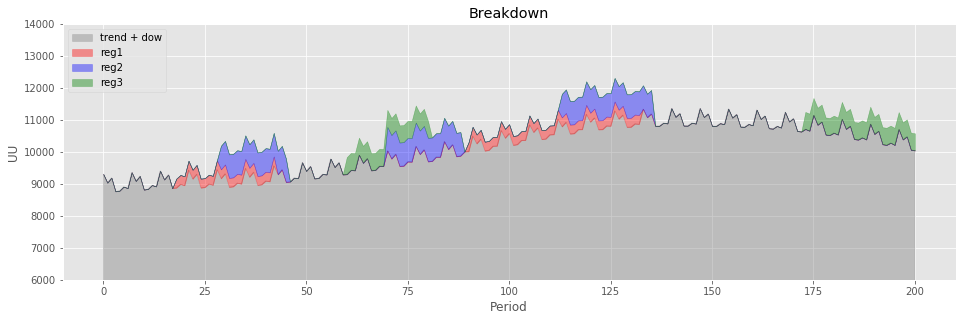

In [13]:
plt.figure(figsize=(16, 16))
plt.subplot(3, 1, 1)

y_a0 = list(map(lambda x: x * y_a[0], x_reg1))
y_a1 = list(map(lambda x: x * y_a[1], x_reg2))
y_a2 = list(map(lambda x: x * y_a[2], x_reg3))

plt.fill_between(x, 
    0, 
    trend + y_dow, 
    alpha=0.4, label='trend + dow', color='gray')
plt.fill_between(x, 
    trend + y_dow, 
    trend + y_dow + y_a0, 
    alpha=0.4, label='reg1', color='red')
plt.fill_between(x, 
    trend + y_dow + y_a0, 
    trend + y_dow + y_a0 + y_a1, 
    alpha=0.4, label='reg2', color='blue')
plt.fill_between(x, 
    trend + y_dow + y_a0 + y_a1, 
    trend + y_dow + y_a0 + y_a1 + y_a2, 
    alpha=0.4, label='reg3', color='green')
plt.ylim(y_min, y_max)
plt.legend(loc='upper left')
plt.xlabel('Period')
plt.ylabel('UU')
plt.title('Breakdown')
plt.show()
plt.show()

## 平均絶対偏差率(Mean Absolute Percentage Error, MAPE)を算出
- このデータセットでは状態空間モデルのほうが精度が良いことがわかる  

In [14]:
def MAPE(true, pred):
    return (abs(pred - true) / true).mean()

mape_ssm = MAPE(y, y_pred)       # State space model
mape_lr = MAPE(y, y_pred_reg)       # Linear regression

print('MAPE in state space model: {:.4f}'.format(mape_ssm))
print('MAPE in linear regression: {:.4f}'.format(mape_lr))

MAPE in state space model: 0.0255
MAPE in linear regression: 0.0704


- 以上の手法では、広告効果は実際は投資額に対して非線形的に変化することが多いようである  
(ex)
https://static.googleusercontent.com/media/research.google.com/ja//pubs/archive/46001.pdf　　
- いつかこの文献のようなモデルも試してみたい